<a href="https://colab.research.google.com/github/EAName/yelp-reviews/blob/main/Yelp_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports 

In [1]:
import pandas as pd
import numpy as np
import os
import random
import numpy as np
import pickle 
import re,string

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, silhouette_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC



from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_predict


import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models import Word2Vec,LdaMulticore, TfidfModel, CoherenceModel
from gensim import corpora
from gensim import similarities
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import LsiModel,LdaModel

from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, GRU
from keras.callbacks import EarlyStopping
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from keras import Input

from IPython.display import display

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
df = pd.read_csv('/content/gdrive/MyDrive/yelp_dataset/yelp_reviews_clean_version4_st_louis.csv')

In [6]:
df.shape

(292376, 5)

**Extract year**

In [7]:
df['review_year'] = df['date'].apply(lambda x:int(x[:4]))

**Look at distribution of reviews by year**

In [8]:
df.review_year.value_counts(ascending= True)

2005       70
2006      314
2007      669
2022     1016
2008     2867
2009     3261
2010     9617
2011    12709
2012    14949
2013    18420
2020    18472
2021    21413
2014    23235
2015    30111
2016    31640
2017    33296
2018    34368
2019    35949
Name: review_year, dtype: int64

**Create 1-0 sentiment flag**

In [9]:
df['sentiment'] = df['stars'].apply(lambda x: 1 if x >= 4 else 0)

**Drop reviews older than 2011**

In [10]:
#df = df[(df['review_year'] > 2011)]

In [11]:
#df.shape

## Text Preprocessing 

In [12]:
def clean_doc(doc): 
    #split review into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]

    #word lemmzatization    
    lemm = WordNetLemmatizer()
    tokens=[lemm.lemmatize(word) for word in tokens]

    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 3]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]     

    # filter out common words
    #tokens = [w for w in tokens if not w in ['movie', 'movies', 'films']]      
    # # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]

    return tokens

def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc

In [13]:
df['cleaned_text'] = df['text'].apply(lambda x: clean_doc(x))

final_processed_text = [' '.join(x) for x in df['cleaned_text'].tolist()]
df['final_processed_text'] = final_processed_text     #add to dataframe

In [14]:
df['text length'] = df['text'].apply(len)

In [15]:
final_processed_text[0]

'love going happy hour dinner great patio beat heat alsovery accomodating location like veal milanese mixed green instead pasta theyll modify menu suit taste'

In [16]:
#df.to_csv('/content/gdrive/MyDrive/data/yelp_reviews_pre_processed_v2.csv', index = False)

In [17]:
#df = pd.read_csv('/content/gdrive/MyDrive/data/yelp_reviews_pre_processed_v2.csv')

In [18]:
df.head()

,user_id,business_id,date,stars,text,review_year,sentiment,cleaned_text,final_processed_text,text length
0,9OAtfnWag-ajVxRbUTGIyg,lj-E32x9_FA7GmUrBGBEWg,2014-06-27 22:44:01,4.0,Love going here for happy hour or dinner! Gre...,2014,1,"[love, going, happy, hour, dinner, great, pati...",love going happy hour dinner great patio beat ...,242
1,5h9JA231vPilNAIjHxwGng,lj-E32x9_FA7GmUrBGBEWg,2014-08-24 19:24:26,5.0,My friends at work (connoisseurs of good food ...,2014,1,"[friend, work, connoisseur, good, food, louis,...",friend work connoisseur good food louis area i...,305
2,c1fSI6Dv5lybr0AJh67e7w,lj-E32x9_FA7GmUrBGBEWg,2015-09-24 15:01:11,4.0,"Great service, relaxing atmosphere and the foo...",2015,1,"[great, service, relaxing, atmosphere, food, e...",great service relaxing atmosphere food excepti...,130
3,st-q1iyW3sJm-v0OCrheoQ,lj-E32x9_FA7GmUrBGBEWg,2015-10-17 04:56:25,5.0,I went to Brio for the first time on Wednesday...,2015,1,"[went, brio, first, time, wednesday, dinner, f...",went brio first time wednesday dinner friend s...,898
4,9qBdzBzoDxLFSMhhGrTWJg,lj-E32x9_FA7GmUrBGBEWg,2016-01-04 16:56:32,4.0,I usually steer clear of the chain restaurants...,2016,1,"[usually, steer, clear, chain, restaurant, sin...",usually steer clear chain restaurant since man...,336


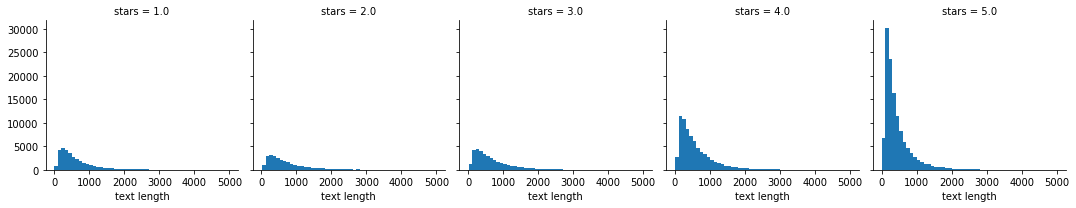

In [19]:
# Lets visualise the review text and stars for a business
g = sns.FacetGrid(data=df, col='stars')
g.map(plt.hist, 'text length', bins=50)

## Create Train/Validation/Test Split

In [20]:
X_train_set, X_nottrain, y_train, y_nottrain = train_test_split(df['final_processed_text'], 
                                                    df['stars'], 
                                                    test_size=0.30, 
                                                    random_state=42)

X_test_set, X_val_set, y_test, y_val = train_test_split(X_nottrain, 
                                                    y_nottrain, 
                                                    test_size=0.5, 
                                                    random_state=42)

In [21]:
X_train_set.head()

246153    mediocre food nothing cracked recommend lunch ...
1749      visited thursday night dinner elsewhere great ...
18036     mediterranean american food intimate upscale s...
118652    excited pretty busy meat dried like sitting he...
147620    told multiple people restaurant great correct ...
Name: final_processed_text, dtype: object

In [22]:
y_train.value_counts()

5.0    86821
4.0    51541
3.0    24769
1.0    23151
2.0    18381
Name: stars, dtype: int64

In [23]:
y_val.value_counts()

5.0    18828
4.0    11164
3.0     5182
1.0     4747
2.0     3936
Name: stars, dtype: int64

In [24]:
y_test.value_counts()

5.0    18598
4.0    10943
3.0     5394
1.0     4975
2.0     3946
Name: stars, dtype: int64

## Feature Engineering

**1-gram Count**

In [25]:
cv = CountVectorizer(binary=False)
cv.fit(X_train_set)
X_train_1gram_count = cv.transform(X_train_set)
X_test_1gram_count = cv.transform(X_test_set)
X_val_1gram_count = cv.transform(X_val_set)

In [26]:
X_train_1gram_count.shape

(204663, 123689)

**1-gram Count, max 10,000 words**

In [27]:
cv = CountVectorizer(binary=False, max_features = 10000)
cv.fit(X_train_set)
X_train_1gram_count_10000 = cv.transform(X_train_set)
X_test_1gram_count_10000 = cv.transform(X_test_set)
X_val_1gram_count_10000 = cv.transform(X_val_set)

In [28]:
X_train_1gram_count_10000.shape

(204663, 10000)

**2-gram Count**

In [29]:
cv = CountVectorizer(binary=False, ngram_range = (1,2))
cv.fit(X_train_set)
X_train_2gram_count = cv.transform(X_train_set)
X_test_2gram_count = cv.transform(X_test_set)
X_val_2gram_count = cv.transform(X_val_set)

In [30]:
X_train_2gram_count.shape

(204663, 2884128)

**2-gram Count, max 10,000 words**

In [31]:
cv = CountVectorizer(binary=False, ngram_range = (1,2), max_features = 10000)
cv.fit(X_train_set)
X_train_2gram_count_10000 = cv.transform(X_train_set)
X_test_2gram_count_10000 = cv.transform(X_test_set)
X_val_2gram_count_10000 = cv.transform(X_val_set)

In [32]:
X_train_2gram_count_10000.shape

(204663, 10000)

**1-gram Tf-Idf**

In [33]:
cv = TfidfVectorizer()
cv.fit(X_train_set)
X_train_1tfidf = cv.transform(X_train_set)
X_test_1tfidf = cv.transform(X_test_set)
X_val_1tfidf = cv.transform(X_val_set)


In [34]:
X_train_1tfidf.shape

(204663, 123689)

**1-gram Tf-Idf, max 10000 words**

In [35]:
cv = TfidfVectorizer(max_features = 10000)
cv.fit(X_train_set)
X_train_1tfidf_10000 = cv.transform(X_train_set)
X_test_1tfidf_10000 = cv.transform(X_test_set)
X_val_1tfidf_10000 = cv.transform(X_val_set)

In [36]:
X_train_1tfidf_10000.shape

(204663, 10000)

**2-gram Tf-Idf**

In [37]:
cv = TfidfVectorizer(ngram_range=(1,2))
cv.fit(X_train_set)
X_train_2tfidf = cv.transform(X_train_set)
X_test_2tfidf = cv.transform(X_test_set)
X_val_2tfidf = cv.transform(X_val_set)

In [38]:
X_train_2tfidf.shape

(204663, 2884128)

**2-gram Tf-Idf, max 10000 words****

In [39]:
cv = TfidfVectorizer(ngram_range=(1,2), max_features = 10000)
cv.fit(X_train_set)
X_train_2tfidf_10000 = cv.transform(X_train_set)
X_test_2tfidf_10000 = cv.transform(X_test_set)
X_val_2tfidf_10000 = cv.transform(X_val_set)

In [40]:
X_train_2tfidf_10000.shape

(204663, 10000)

In [41]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    ax.xaxis.set_ticklabels(['1', '2', '3', '4', '5'])
    ax.yaxis.set_ticklabels(['1', '2', '3', '4', '5'])

In [42]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {:.3f}'.format(accuracy_score(test_labels, predictions)))
    print('Mean Absolute Error: {:.3f}'.format(mean_absolute_error(test_labels, predictions)))
    print('Root Mean Square Error: {:.3f}'.format(np.sqrt(MSE(test_labels, predictions))))
    print('Mean Square Error: {:.3f}'.format(MSE(test_labels, predictions, squared = True)))

## Modeling

###Naive Bayes

In [89]:
list1 = [X_train_1gram_count, X_train_1gram_count_10000, X_train_2gram_count, X_train_2gram_count_10000, X_train_1tfidf, X_train_1tfidf_10000, X_train_2tfidf, X_train_2tfidf_10000]
list2 = [X_test_1gram_count, X_test_1gram_count_10000, X_test_2gram_count, X_test_2gram_count_10000, X_test_1tfidf, X_test_1tfidf_10000, X_test_2tfidf, X_test_2tfidf_10000]
list3 = ['1-gram count', '1-gram count max 10,000 words', '2-gram count', '2-gram count, max 10,000 words', '1-gram tf-idf', '1-gram tf-idf max 10,000 words', '2-gram tf-idf', '2-gram tf-idf, max 10,000 words']
for i,j,k in zip(list1, list2, list3):
  nb.fit(i, y_train)
  preds = nb.predict(j)
  print(k)
  print(print_validation_report(y_test,preds),'\n')


1-gram count
Classification Report
              precision    recall  f1-score   support

         1.0       0.62      0.72      0.67      4975
         2.0       0.39      0.24      0.30      3946
         3.0       0.43      0.30      0.35      5394
         4.0       0.49      0.48      0.49     10943
         5.0       0.73      0.84      0.78     18598

    accuracy                           0.61     43856
   macro avg       0.53      0.51      0.52     43856
weighted avg       0.59      0.61      0.60     43856

Accuracy Score: 0.614
Mean Absolute Error: 0.489
Root Mean Square Error: 0.878
Mean Square Error: 0.771
None 

1-gram count max 10,000 words
Classification Report
              precision    recall  f1-score   support

         1.0       0.62      0.70      0.66      4975
         2.0       0.37      0.33      0.35      3946
         3.0       0.43      0.38      0.40      5394
         4.0       0.51      0.46      0.48     10943
         5.0       0.75      0.81      0.7

In [101]:
nb = MultinomialNB()
nb.fit(X_train_2gram_count_10000, y_train)

MultinomialNB()

In [102]:
preds = nb.predict(X_test_2gram_count_10000)

In [103]:
print(print_validation_report(y_test,preds))

Classification Report
              precision    recall  f1-score   support

         1.0       0.65      0.71      0.68      4975
         2.0       0.40      0.37      0.38      3946
         3.0       0.44      0.42      0.43      5394
         4.0       0.52      0.49      0.51     10943
         5.0       0.77      0.79      0.78     18598

    accuracy                           0.63     43856
   macro avg       0.56      0.56      0.56     43856
weighted avg       0.62      0.63      0.62     43856

Accuracy Score: 0.625
Mean Absolute Error: 0.465
Root Mean Square Error: 0.846
Mean Square Error: 0.715
None


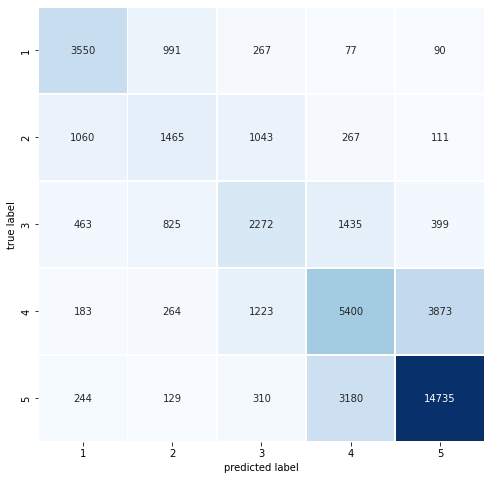

In [104]:
plot_confusion_matrix(y_test,preds)

###Logistic Regression

In [39]:
#2-gram count with maximum 10,000 words
for c in [0.01, 0.05, 0.25, 0.5, 1]:
  lr = LogisticRegression(C=c, max_iter= 300)
  lr.fit(X_train_2gram_count_10000, y_train)
  preds = lr.predict(X_test_2gram_count_10000)
  print("For C = %s" % (c))
  print(print_validation_report(y_test,preds), '\n')

For C = 0.01
Classification Report
              precision    recall  f1-score   support

         1.0       0.69      0.78      0.73      4975
         2.0       0.48      0.31      0.38      3946
         3.0       0.51      0.35      0.42      5394
         4.0       0.54      0.44      0.48     10943
         5.0       0.71      0.89      0.79     18598

    accuracy                           0.64     43856
   macro avg       0.59      0.55      0.56     43856
weighted avg       0.62      0.64      0.62     43856

Accuracy Score: 0.644
Mean Absolute Error: 0.446
Root Mean Square Error: 0.838
Mean Square Error: 0.703
None 

For C = 0.05
Classification Report
              precision    recall  f1-score   support

         1.0       0.69      0.77      0.73      4975
         2.0       0.48      0.35      0.41      3946
         3.0       0.50      0.38      0.43      5394
         4.0       0.54      0.45      0.49     10943
         5.0       0.73      0.87      0.79     18598

    

In [43]:
# 2 gram tf-idf with maximum 10,000 words
for c in [0.01, 0.05, 0.25, 0.5, 1]:
  lr = LogisticRegression(C=c, max_iter= 300)
  lr.fit(X_train_2tfidf_10000, y_train)
  preds = lr.predict(X_test_2tfidf_10000)
  print("For C = %s" % (c))
  print(print_validation_report(y_test,preds), '\n')

For C = 0.01
Classification Report
              precision    recall  f1-score   support

         1.0       0.68      0.62      0.65      4975
         2.0       0.47      0.01      0.02      3946
         3.0       0.41      0.05      0.09      5394
         4.0       0.40      0.33      0.36     10943
         5.0       0.59      0.93      0.72     18598

    accuracy                           0.56     43856
   macro avg       0.51      0.39      0.37     43856
weighted avg       0.52      0.56      0.48     43856

Accuracy Score: 0.556
Mean Absolute Error: 0.711
Root Mean Square Error: 1.236
Mean Square Error: 1.529
None 

For C = 0.05
Classification Report
              precision    recall  f1-score   support

         1.0       0.68      0.77      0.72      4975
         2.0       0.50      0.20      0.28      3946
         3.0       0.50      0.26      0.34      5394
         4.0       0.50      0.46      0.48     10943
         5.0       0.69      0.89      0.78     18598

    

In [44]:
lr = LogisticRegression()
lr.fit(X_train_2tfidf_10000, y_train)

LogisticRegression()

In [45]:
preds = lr.predict(X_test_2tfidf_10000)

In [46]:
print(print_validation_report(y_test,preds))

Classification Report
              precision    recall  f1-score   support

         1.0       0.70      0.77      0.73      4975
         2.0       0.47      0.36      0.41      3946
         3.0       0.50      0.39      0.44      5394
         4.0       0.54      0.49      0.51     10943
         5.0       0.75      0.85      0.80     18598

    accuracy                           0.65     43856
   macro avg       0.59      0.57      0.58     43856
weighted avg       0.64      0.65      0.64     43856

Accuracy Score: 0.652
Mean Absolute Error: 0.418
Root Mean Square Error: 0.779
Mean Square Error: 0.607
None


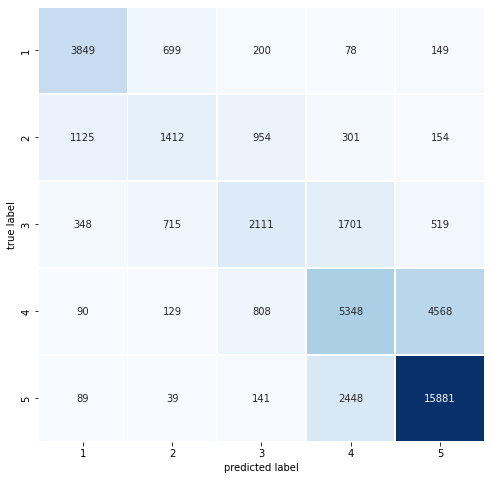

In [47]:
plot_confusion_matrix(y_test,preds)

In [54]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), lr.coef_[0]
    )
}
print("Best Positive")
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:50]:
    print (best_positive)

print("Best Negative")

for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1],
    reverse=True)[:50]:
    print (best_negative)

Best Positive
('delicious', -10.733842245104999)
('great', -9.274891444548917)
('amazing', -8.059261860198104)
('excellent', -7.460489159552636)
('tasty', -6.2918047160668245)
('good', -6.249419772798257)
('best', -5.84730426814659)
('awesome', -5.807411526965785)
('love', -5.803560197769274)
('fantastic', -5.22574855134141)
('perfect', -4.8650444076302275)
('friendly', -4.854824594287425)
('loved', -4.629120850625488)
('favorite', -4.540386154355375)
('enjoyed', -4.3758407827322845)
('nice', -4.365506684207035)
('star', -4.1689478871198125)
('little', -4.104164209041819)
('wonderful', -4.052499025230858)
('always', -3.9787242650702574)
('definitely', -3.7553513543058803)
('outstanding', -3.489690856980386)
('attentive', -3.440553663065543)
('food good', -3.3163593429347897)
('perfectly', -3.3089691874827354)
('yummy', -3.2402056673829636)
('flavorful', -2.9943405099467943)
('atmosphere', -2.9557894470739194)
('clean', -2.7206895710946815)
('complaint', -2.7151981076976273)
('happy', -

**Baseline Random Forest**

In [ ]:
#rf = RandomForestClassifier(max_features = 'sqrt')
#rf.fit(X_train_2tfidf_10000, y_train)

In [ ]:
#preds = rf.predict(X_test_2tfidf_10000)